In [157]:
import numpy as np
import pandas as pd
from pathlib import Path

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import matplotlib.pyplot as plt

In [158]:
emails_df = pd.read_csv('data/v1.csv')
print(emails_df.shape)
emails_df.head(1)

(1961, 8)


,Unnamed: 0,id_mail,date,from,to,subject,body,x_origin
0,0,<24597416.1075840072483.JavaMail.evans@thyme>,"Fri, 28 Jul 2000 07:02:00 -0700 (PDT)",bill.haack@haack.com,jeff.skilling@enron.com,FW: YPO Area conference dates,"Obviously, these dates are for year 2001!\n\n>...",SKILLING-J


In [159]:
emails_df = emails_df.set_index('id_mail')
emails_df['date'] = pd.to_datetime(emails_df['date'], infer_datetime_format=True)
emails_df.dtypes

Unnamed: 0     int64
date          object
from          object
to            object
subject       object
body          object
x_origin      object
dtype: object

In [160]:
emails_df.head(1)

,Unnamed: 0,date,from,to,subject,body,x_origin
id_mail,,,,,,,
<24597416.1075840072483.JavaMail.evans@thyme>,0,2000-07-28 07:02:00-07:00,bill.haack@haack.com,jeff.skilling@enron.com,FW: YPO Area conference dates,"Obviously, these dates are for year 2001!\n\n>...",SKILLING-J


In [161]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent","aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    
    return normalized

In [162]:
analysis_df=emails_df[['from', 'to', 'date','body']].dropna().copy()
# analysis_df = analysis_df.loc[analysis_df['to'].map(len) == 1]
# sub_df=analysis_df.sample(1000)

In [163]:
analysis_df.head(1)

,from,to,date,body
id_mail,,,,
<24597416.1075840072483.JavaMail.evans@thyme>,bill.haack@haack.com,jeff.skilling@enron.com,2000-07-28 07:02:00-07:00,"Obviously, these dates are for year 2001!\n\n>..."


In [164]:
text_clean=[]
for text in analysis_df['body']:
    text_clean.append(clean(text).split())

# document matrix

In [165]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

## LDA

In [166]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=5, id2word = dictionary, passes=30)

In [179]:
eng_stopwords = set(stopwords.words('english'))
my_stopwords = eng_stopwords.union(['ect', 'hou', 'com', 'recipient', 'sent', 'enron', 'cc', 'subject',\
                                         'forwarded', 'corp', 'said', 'attached', 'ect',\
                                         'recipient', 'email', 'original', 'doc', 'pm', 'mail', 'message', 'new'\
                                         'enronxgate', 'na', 'year','please'])

In [180]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in my_stopwords]
    words = [w for w in words if len(w) > 3]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.body.apply(clean_text)

In [171]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(1000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names_out()

# inspect LDA model

In [178]:
print(ldamodel.show_topics())

[(0, '0.007*"one" + 0.006*"get" + 0.005*"com" + 0.005*"time" + 0.004*"like" + 0.004*"mark" + 0.004*"would" + 0.004*"year" + 0.004*"know" + 0.003*"day"'), (1, '0.020*"enron" + 0.014*"jeff" + 0.011*"would" + 0.010*"com" + 0.009*"please" + 0.008*"skilling" + 0.008*"meeting" + 0.007*"know" + 0.006*"time" + 0.006*"mr"'), (2, '0.007*"e" + 0.007*"www" + 0.006*"energy" + 0.006*"business" + 0.006*"new" + 0.005*"market" + 0.005*"u" + 0.005*"enron" + 0.005*"service" + 0.004*"company"'), (3, '0.054*"com" + 0.008*"compaq" + 0.008*"net" + 0.008*"e" + 0.005*"aol" + 0.005*"mail" + 0.005*"report" + 0.004*"beta" + 0.004*"please" + 0.004*"c"'), (4, '0.127*"enron" + 0.040*"ect" + 0.025*"development" + 0.024*"corp" + 0.024*"hou" + 0.016*"communication" + 0.015*"ee" + 0.006*"na" + 0.006*"mark" + 0.005*"pm"')]


In [175]:
print(ldamodel.num_topics)

5


In [176]:
ldamodel.get_topics()

array([[2.5627576e-04, 2.7355782e-05, 8.6010230e-04, ..., 4.3446516e-06,
        4.3423865e-06, 4.3446503e-06],
       [1.0908883e-03, 1.3588356e-04, 7.8644045e-04, ..., 2.2456359e-06,
        2.2456602e-06, 2.2456325e-06],
       [5.1484240e-04, 2.0238965e-06, 1.0784013e-03, ..., 2.0211585e-06,
        2.0212456e-06, 2.0211960e-06],
       [1.3274253e-04, 4.4158933e-06, 1.9225910e-04, ..., 4.1601975e-06,
        4.1604058e-06, 4.1600556e-06],
       [2.7900614e-04, 5.2652072e-06, 5.6445710e-06, ..., 3.1280717e-05,
        5.7549023e-05, 3.1280826e-05]], dtype=float32)

# >>>>>>>>>>>>>>>>IGNORE

# K-mean

In [90]:
N = 10
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [66]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/hsinhan/PycharmProjects/Enron_Email_Usecase/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


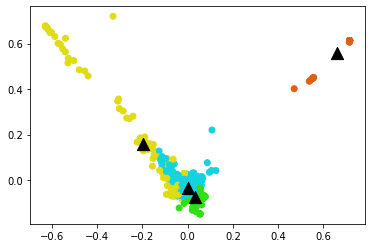

In [69]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0"]
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()